In [1868]:
from bs4 import BeautifulSoup
import re
import urllib.request
from urllib.request import Request, urlopen, quote
import requests
import socket
import numpy as np
import json
import os
import sys
import nltk
import pandas as pd
from collections import namedtuple
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
# gensim
import gensim
from gensim import corpora, models, similarities, matutils
from gensim import utils
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import TaggedDocument

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from wordcloud import WordCloud

from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

In [2060]:
import plotly as py
import plotly.graph_objs as go
import csv

## Genius.com Scraping Exploration (not relevant)

In [439]:
URL = 'https://genius.com/Mansionz-my-beloved-lyrics'
#URL = 'https://genius.com/Drake-more-life-credits-annotated'
page = requests.get(URL)    
html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string
song_info = []

# Song name
song_name = html.find("h1", class_="header_with_cover_art-primary_info-title").get_text().encode('ascii','ignore').decode('ascii')
#print(song_name)
song_info.append(song_name)

# Artist
artist = html.find("a",class_='header_with_cover_art-primary_info-primary_artist').get_text().encode('ascii','ignore').decode('ascii')
#print(artist)
song_info.append(artist)

# Album
album = html.find("a", class_="song_album-info-title").get_text().encode('ascii','ignore').decode('ascii')
album = re.sub(' ','',album)  # Remove spaces 
album = re.sub('\n','',album)  # Remove new lines        
#print(album)
song_info.append(album)

print('\n')

# Lyrics
lyrics = html.find("div", class_="lyrics").get_text().encode('ascii','ignore').decode('ascii')
lyrics = re.sub('\[.*\]','',lyrics) # Remove [Verse] and [Bridge] stuff
lyrics = re.sub('\n',' ',lyrics)  # Remove gaps between verses        
#lyrics = str(lyrics).strip('\n')
#lyrics_clean = lyrics
#print(lyrics)
song_info.append(lyrics)
print(song_info)
print(lyrics)



['My Beloved', 'mansionz', 'Mansionz', "   Just your flock, just your companians Just your kids, just your cheeks Just your neck, just your couch And my perfume, and my beloved And my breasts, and my beloved And my love   Yeah, I'm drowning in my own genius, that's what I'd like to think That's the attitude I've taken on these type of things A man can never own a woman, he just thinks he does Add it to the list of the dirty shit I'm thinking up Just tryna lighten up your mood, but you prefer it dark Soften all of the places up that were hard Put a couple of my kisses on your birthmarks I think you're hiding who you are and that's the worst part I never wanted to own you, just your neck Just your good needs, just your two breasts Just the good parts of you and your perfume, baby Don't ask the sun to shine more like the moon, baby   Just your neck, just my couch Just your perfume, and my beloved And your wrists, just my couch And my love   Yeah, I was just seeing double, you look like 

In [265]:
song_info = []
song_info.append(lyrics)
#print(lyrics)
print(song_info)

Keep your distance from her
Keep your distance from her
Keep your distance from her
Keep your distance from her

Would you give me a moment? Give me a try
Don't leave me hanging, no, that isn't right
Why do we do this? Throw me a lie
You like the attention, and you get what you like

I just wanna get you closer
I don't wanna play these games
All you wanna be is wanted
Makes your ego okay
Why you gotta tease me, baby?
Why you gotta play these games?
Every time you come over
I don't ever get no play

She's fucking wicked
But I love the way she hurts me
I'm so addicted to her loving
That girl is vicious
When you see her, be sure
That you're keeping your distance
From her loving

I'm being the good guy, I'm being polite
You tell me I'm too nice, maybe you're right
And I don't wanna hear that, I ain't your type
What does that even mean, girl? Can I get a reply?

I just wanna get you closer
I don't wanna play this games
All you wanna be is wanted
Make sure he go, "Okay"
Why you gotta tease m

In [262]:
song_info[3] = re.sub(r'\[.*\]','',song_info[3]) # Remove [Verse] and [Bridge] stuff
song_info[3] = re.sub('\n','',song_info[3]) # some weird stuff happening when I append lyrics, so gotta clean it again

In [263]:
song_info

['Wicked',
 'mansionz',
 'Mansionz',
 'Keep your distance from herKeep your distance from herKeep your distance from herKeep your distance from herWould you give me a moment? Give me a tryDon\'t leave me hanging, no, that isn\'t rightWhy do we do this? Throw me a lieYou like the attention, and you get what you likeI just wanna get you closerI don\'t wanna play these gamesAll you wanna be is wantedMakes your ego okayWhy you gotta tease me, baby?Why you gotta play these games?Every time you come overI don\'t ever get no playShe\'s fucking wickedBut I love the way she hurts meI\'m so addicted to her lovingThat girl is viciousWhen you see her, be sureThat you\'re keeping your distanceFrom her lovingI\'m being the good guy, I\'m being politeYou tell me I\'m too nice, maybe you\'re rightAnd I don\'t wanna hear that, I ain\'t your typeWhat does that even mean, girl? Can I get a reply?I just wanna get you closerI don\'t wanna play this gamesAll you wanna be is wantedMake sure he go, "Okay"Why 

## Functions to ultimately end up with a big list

In [429]:
def artist_album_list(artist_list):
    '''Takes a list of artists, returns list of their albums in order of input index (artist index)'''
    album_urls = []
    for i,_ in enumerate(artist_list):
        artist = str(artist_list[i])
        artist = re.sub(' ', '-', artist)
        #artist = str(artist)
        #artist = str(artist_list[i])
        base_artist_url = 'https://genius.com/artists/'
        artist_url = base_artist_url + artist
        #page = requests.get(artist_url)    
        #html = BeautifulSoup(page.text, "html.parser") this one also works
        r = requests.get(artist_url)
        soup = BeautifulSoup(r.content, 'lxml')
        for a in soup.find_all('a',{'class': 'vertical_album_card'}, ['href']):
            album_urls.append(a['href'])
    return album_urls

In [406]:
def album_song_list(album_urls):
    ''' Takes the list of albums and returns a list of songs in those albums'''
    song_urls = []
    for i,_ in enumerate(album_urls):
        r = requests.get(album_urls[i])
        soup = BeautifulSoup(r.content, 'lxml')
        for div in soup.find_all('div',{'class': 'chart_row chart_row--light_border chart_row--full_bleed_left chart_row--align_baseline chart_row--no_hover'}):
            if len(div.span.span.text) > 0: # The only thing that distinguishes between songs and extra links is the span #
                song_urls.append(div.a['href'])
    return song_urls

In [407]:
album_song_list(album_urls)

['https://genius.com/Drake-gods-plan-lyrics',
 'https://genius.com/Drake-diplomatic-immunity-lyrics',
 'https://genius.com/Drake-free-smoke-lyrics',
 'https://genius.com/Drake-no-long-talk-lyrics',
 'https://genius.com/Drake-passionfruit-lyrics',
 'https://genius.com/Drake-jorja-interlude-lyrics',
 'https://genius.com/Drake-get-it-together-lyrics',
 'https://genius.com/Drake-madiba-riddim-lyrics',
 'https://genius.com/Drake-blem-lyrics',
 'https://genius.com/Drake-4422-lyrics',
 'https://genius.com/Drake-gyalchester-lyrics',
 'https://genius.com/Drake-skepta-interlude-lyrics',
 'https://genius.com/Drake-portland-lyrics',
 'https://genius.com/Drake-sacrifices-lyrics',
 'https://genius.com/Drake-nothings-into-somethings-lyrics',
 'https://genius.com/Drake-teenage-fever-lyrics',
 'https://genius.com/Drake-kmt-lyrics',
 'https://genius.com/Drake-lose-you-lyrics',
 'https://genius.com/Drake-cant-have-everything-lyrics',
 'https://genius.com/Drake-glow-lyrics',
 'https://genius.com/Drake-sin

In [1803]:
def lyrics(song_urls):
    song_info = []
    for i,_ in enumerate(song_urls):
        page = requests.get(song_urls[i])    
        html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string

        # Song name
        try:
            song_name = html.find("h1", class_="header_with_cover_art-primary_info-title").get_text().encode('ascii','ignore').decode('ascii')
            artist = html.find("a",class_='header_with_cover_art-primary_info-primary_artist').get_text().encode('ascii','ignore').decode('ascii')
            album = html.find("a", class_="song_album-info-title").get_text().encode('ascii','ignore').decode('ascii')
            lyrics = html.find("div", class_="lyrics").get_text().encode('ascii','ignore').decode('ascii')
            lyrics = html.find("div", class_="lyrics").get_text().encode('ascii','ignore').decode('ascii')
            lyrics = re.sub('\[.*\]','',lyrics) # Remove [Verse] and [Bridge] stuff
            lyrics = re.sub('\n',' ',lyrics)  # Remove gaps between verses
            song_info.append(song_name)
            song_info.append(artist)
            song_info.append(album)
            song_info.append(lyrics)
        except:
            pass
    return song_info

In [1043]:
# Billboard Top 100 Artists

top_100_artists = []
url = 'https://www.billboard.com/charts/artist-100'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'lxml')
#for div in 
for i,_ in enumerate(soup.find_all("a", {'class':'chart-row__artist'})):
    name = _.get_text()
    name = re.sub("\n", '', name)
    name = re.sub(' Marshmello', 'Marshmello', name)
    name = re.sub(' DJ Khaled', 'DJ Khaled', name)
    name = re.sub('\$', 'S', name)
    name = re.sub('\!', 'i', name)
    name = re.sub('\.', '', name)
    top_100_artists.append(name)
#top_100_artists = re.sub('\n','',top_100_artists)
    
#top_100_artists = html.find("div", class_="lyrics").get_text().encode('ascii','ignore').decode('ascii')

top_100_artists = top_100_artists + ['21 savage', '5 seconds of summer', '6ix9ine']

In [ ]:
# Billboard Top 50 R&B / Hip Hop Albums

top_rapbums = []
url = 'https://www.billboard.com/charts/r-b-hip-hop-albums'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'lxml')



In [ ]:
# Billboard hot 100 songs

hot_100 = []
url = 'https://www.billboard.com/charts/hot-100'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'lxml')
for i,_ in enumerate(soup.find_all('h2', {'class': 'chart-row__song'})):
    name = _.get_text()
    name = re.sub("Him & I",'', name)
    
    hot_100.append(name)
hot_100 + ['44 more', 'G-eazy-and-halsey-him-and-i-lyrics']

In [866]:
def artist_album_list(artist_list):
    '''Takes a list of artists, returns list of their albums in order of input index (artist index)'''
    album_urls = []
    for i,_ in enumerate(artist_list):
        artist = str(artist_list[i])
        artist = re.sub(' ', '-', artist)
        #artist = str(artist)
        #artist = str(artist_list[i])
        base_artist_url = 'https://genius.com/artists/'
        artist_url = base_artist_url + artist
        #page = requests.get(artist_url)    
        #html = BeautifulSoup(page.text, "html.parser") this one also works
        r = requests.get(artist_url)
        soup = BeautifulSoup(r.content, 'lxml')
        for a in soup.find_all('a',{'class': 'vertical_album_card'}, ['href']):
            album_urls.append(a['href'])
    return album_urls

In [886]:
# artist_list_rappers = ['drake', 'post malone', 'kendrick lamar', 'nicki minaj', 'migos', 'logic',
#                        'future', 'kyle', 'the weeknd']

extra_albums = ['https://genius.com/albums/Drake/Thank-me-later',
                'https://genius.com/albums/Drake/So-far-gone',
                'https://genius.com/albums/Drake/Comeback-season',
                'https://genius.com/albums/Drake/Room-for-improvement',
                'https://genius.com/albums/Kendrick-lamar/Section-80',
                'https://genius.com/albums/Kendrick-lamar/Overly-dedicated',
                'https://genius.com/albums/Kendrick-lamar/The-kendrick-lamar-ep',
                'https://genius.com/albums/Kendrick-lamar/C4',
                'https://genius.com/albums/Nicki-minaj/Beam-me-up-scotty',
                'https://genius.com/albums/Nicki-minaj/Sucka-free',
                'https://genius.com/albums/Nicki-minaj/Playtime-is-over',
                'https://genius.com/albums/Migos/Back-to-the-bando',
                'https://genius.com/albums/Migos/Yung-rich-nation',
                'https://genius.com/albums/Migos/Migo-lingo',
                'https://genius.com/albums/Migos/Rich-nigga-timeline',
                'https://genius.com/albums/Migos/No-label-ii',
                'https://genius.com/albums/Migos/Young-rich-niggas',
                'https://genius.com/albums/Migos/No-label',
                'https://genius.com/albums/Migos/Juug-season',
                'https://genius.com/albums/Logic/Young-sinatra-undeniable',
                'https://genius.com/albums/Logic/Young-broke-and-infamous',
                'https://genius.com/albums/The-weeknd/Thursday',
                'https://genius.com/albums/The-weeknd/House-of-balloons',
                'https://genius.com/albums/The-weeknd/The-noise-ep',
                'https://genius.com/albums/Future/Beast-mode',
                'https://genius.com/albums/Future/Monster',
                'https://genius.com/albums/Future/Honest',
                'https://genius.com/albums/Future/No-sleep',
                'https://genius.com/albums/Future/Pluto-3d',
                'https://genius.com/albums/Future/Welcome-2-mollyworld',
                'https://genius.com/albums/Future/Pluto']

In [887]:
dupes = ['https://genius.com/albums/Kendrick-lamar/Damn-collectors-edition',
         'https://genius.com/albums/Nicki-minaj/Pink-friday-roman-reloaded',
         #'https://genius.com/albums/Logic/Under-pressure-commentary-version',
         'https://genius.com/albums/Eminem/Relapse-refill']

## Parse our scraping of top 50 artists into five chunks

In [1055]:
one = artist_album_list(top_100_artists[:10])
two = album_song_list(one)
three = lyrics(two)

v222 = artist_album_list(top_100_artists[10:20])
v22 = album_song_list(v222)
v2 = lyrics(v22)

v2 = lyrics([ x for x in v22 if "remix" not in x ])

v333 = artist_album_list(top_100_artists[20:30])
v33 = album_song_list(v333)
v3 = lyrics([ x for x in v33 if "remix" not in x ])

v444 = artist_album_list(top_100_artists[30:40])
v44 = album_song_list(v444)
v4 = lyrics([ x for x in v44 if "remix" not in x ])

v555 = artist_album_list(top_100_artists[40:50])
v55 = album_song_list(v555)
v5 = lyrics([ x for x in v55 if "remix" not in x ])

v1 = lyrics([ x for x in this if "remix" not in x ])

lyrics_info = v1+v2+v3+v4+v5

In [ ]:
# Hacky way of making a pandas DF of our data

lyricsdf = pd.DataFrame(lyrics_info)

lyricsdf.iloc[0::4, :] # song titles
lyricsdf.iloc[1::4, :] # artists
lyricsdf.iloc[2::4, :] # albums
lyricsdf.iloc[3::4, :] # lyrics

test = pd.DataFrame()
q_songs = lyricsdf.iloc[0::4, :]
q_artists = lyricsdf.iloc[1::4, :]
q_albums = lyricsdf.iloc[2::4, :]
q_lyrics = lyricsdf.iloc[3::4, :]


q_songs = q_songs.reset_index()
q_artists = q_artists.reset_index()
q_albums = q_albums.reset_index()
q_lyrics = q_lyrics.reset_index()

test = pd.concat([q_songs, q_artists, q_albums, q_lyrics], axis=1, ignore_index=True)

test = test.drop(test.columns[[0, 2, 4, 6]], axis=1)

test.columns = ['song', 'artist', 'album', 'lyrics']

test
test.to_csv('lyrics.txt', sep='\t')

## Putting data into mongo

In [450]:
from pymongo import MongoClient

In [ ]:
cd .ssh/
ssh -i "Metis.pem" ubuntu@ec2-18-222-51-77.us-east-2.compute.amazonaws.com

sudo service mongod start
mongo

In [ ]:
........

## LDA Topic Modeling

In [1839]:
lyrics_only = lyrics_info[3::4]

In [1840]:
len(lyrics_only)

3023

In [1545]:
f = open('/Users/Dereck/ds/Project_4/stop_words.txt', 'r')
x = f.readlines()
#x.replace('\n', '')
for a in x:
    a = re.sub("\n", '', a)

In [1546]:
stop = [a.rstrip('\n') for a in x]
stop+=['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii',
       'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii',
       'xviii', 'xix', 'xx', 'xxi', 'xxii', 'xxiii', 'xxiv', 'xxv',
       'xxvi', 'xxvii', 'xxviii', 'xxix', 'xxx', 'xxxi', 'xxxii',
       'xxxiii', 'xxxiv', 'xxxv', 'xxxvi', 'xxxvii', 'xxxviii', 'xxxix',
       'xl', 'xli', 'xlii', 'xliii', 'xliv', 'xlv', 'xlvi', 'xlvii',
       'xlviii', 'xlix', 'l', 'li', 'lii', 'liii', 'liv', 'lv', 'lvi',
       'lvii', 'lviii', 'lix', 'lx', 'lxi', 'lxii', 'lxiii', 'lxiv',
       'lxv', 'lxvi', 'lxvii', 'lxviii', 'lxix', 'lxx', 'lxxi', 'lxxii',
       'lxxiii', 'lxxiv', 'lxxv', 'lxxvi', 'lxxvii', 'lxxviii', 'lxxix',
       'lxxx', 'lxxxi', 'lxxxii', 'lxxxiii', 'lxxxiv', 'lxxxv', 'lxxxvi',
       'lxxxvii', 'lxxxviii', 'lxxxix', 'xc', 'xci', 'xcii', 'xciii',
       'xciv', 'xcv', 'xcvi', 'xcvii', 'xcviii', 'xcix', 'c', 'cc', 'ccc',
       'cd', 'd', 'dc', 'dcc', 'dccc', 'cm', 'm', 'v', 'x', 'l', 'c', 'd',
       'm', '?','!','.',',',':',';', "'", '"']
stop += ['yeah', 'don', 't', 'like', 'just', 'oh', 'que', 'la', 'lo', 'tu', 'se', 'en', 'te', 'como', 'el', 'yo',
         'aaah', 'queso', 'blas', 'har', 'ber', 'whoo', 'neol', 'nae', 'nan', 'deo', 'su', 'dasi', 'instrumental', 
         'neoui', 'geu', 'geol', 'll', 'got', 'oh']
stop += ['ain', 've', 'wanna', 'dah', 'marshmello', 'de', 'da', 'hee', 'cant', 'baby', 'mi', 'nal', 'je']
stop += ['em', 'man', 'ooh', 'gon', 'dont', 'ya', 'ma', 'going', 'won', 'bad']
stop += ['hey', 'dwae', 'woo', 'brr', 'errthing', 'clack', 'click', 'nigga', 'niggas', 'girl', 'girls', 'boy']

In [1841]:
tfidf_vectorizer = TfidfVectorizer(stop_words = stop, token_pattern="\\b[a-z][a-z]+\\b", min_df = 0.05)


tfidf_vectorizer.fit(lyrics_only) 

tfidf = tfidf_vectorizer.transform(lyrics_only).transpose() # calculates the word count and puts that data in the
                                                               # document matrix; outputs sparse matrix

pd.DataFrame(tfidf.toarray(), tfidf_vectorizer.get_feature_names()).head()

corpus = matutils.Sparse2Corpus(tfidf)

id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

#lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10)

#lda.print_topics()

In [1309]:
lda2 = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10)

lda2.print_topics(num_words = 20)

2018-03-07 12:00:31,751 : INFO : using symmetric alpha at 0.2
2018-03-07 12:00:31,753 : INFO : using symmetric eta at 0.2
2018-03-07 12:00:31,754 : INFO : using serial LDA version on this node
2018-03-07 12:00:31,765 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 3023 documents, updating model once every 2000 documents, evaluating perplexity every 3023 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-07 12:00:31,789 : INFO : PROGRESS: pass 0, at document #2000/3023
2018-03-07 12:00:34,074 : INFO : merging changes from 2000 documents into a model of 3023 documents
2018-03-07 12:00:34,079 : INFO : topic #0 (0.200): 0.019*"feel" + 0.017*"shit" + 0.017*"fuck" + 0.015*"love" + 0.013*"life" + 0.013*"time" + 0.012*"better" + 0.012*"bitch" + 0.012*"hey" + 0.010*"people"
2018-03-07 12:00:34,080 : INFO : topic #1 (0.200): 0.046*"love" + 0.015*"shit" + 0.015*"feel" + 0.013*"time" + 0.012*"day" + 0.011*"night" + 0.010*"fa

2018-03-07 12:00:45,267 : INFO : topic diff=0.178430, rho=0.470803
2018-03-07 12:00:45,283 : INFO : PROGRESS: pass 3, at document #2000/3023
2018-03-07 12:00:47,365 : INFO : merging changes from 2000 documents into a model of 3023 documents
2018-03-07 12:00:47,369 : INFO : topic #0 (0.200): 0.036*"bitch" + 0.034*"shit" + 0.033*"nigga" + 0.030*"fuck" + 0.025*"niggas" + 0.020*"money" + 0.012*"bitches" + 0.012*"real" + 0.011*"hit" + 0.011*"tryna"
2018-03-07 12:00:47,370 : INFO : topic #1 (0.200): 0.077*"love" + 0.030*"feel" + 0.022*"will" + 0.017*"heart" + 0.017*"leave" + 0.015*"time" + 0.014*"fall" + 0.013*"coming" + 0.011*"stay" + 0.011*"life"
2018-03-07 12:00:47,372 : INFO : topic #2 (0.200): 0.034*"girl" + 0.025*"hey" + 0.022*"night" + 0.017*"love" + 0.013*"time" + 0.012*"keep" + 0.012*"alright" + 0.011*"good" + 0.011*"crazy" + 0.010*"ride"
2018-03-07 12:00:47,373 : INFO : topic #3 (0.200): 0.019*"love" + 0.016*"song" + 0.015*"girl" + 0.015*"eyes" + 0.014*"night" + 0.013*"dance" + 0.0

2018-03-07 12:00:59,291 : INFO : topic #0 (0.200): 0.037*"bitch" + 0.037*"shit" + 0.035*"nigga" + 0.032*"fuck" + 0.027*"niggas" + 0.022*"money" + 0.013*"bitches" + 0.012*"real" + 0.012*"tryna" + 0.012*"fuckin"
2018-03-07 12:00:59,292 : INFO : topic #1 (0.200): 0.077*"love" + 0.033*"feel" + 0.026*"will" + 0.019*"heart" + 0.017*"leave" + 0.015*"stay" + 0.015*"fall" + 0.014*"time" + 0.014*"coming" + 0.013*"hold"
2018-03-07 12:00:59,294 : INFO : topic #2 (0.200): 0.036*"girl" + 0.028*"hey" + 0.022*"night" + 0.018*"love" + 0.015*"time" + 0.013*"alright" + 0.013*"good" + 0.012*"crazy" + 0.011*"tonight" + 0.011*"ride"
2018-03-07 12:00:59,295 : INFO : topic #3 (0.200): 0.017*"song" + 0.017*"love" + 0.016*"dance" + 0.015*"eyes" + 0.015*"night" + 0.014*"girl" + 0.014*"lights" + 0.013*"fire" + 0.012*"forever" + 0.012*"good"
2018-03-07 12:00:59,296 : INFO : topic #4 (0.200): 0.021*"gonna" + 0.020*"life" + 0.020*"time" + 0.020*"love" + 0.017*"heart" + 0.015*"mind" + 0.015*"things" + 0.014*"find" + 

2018-03-07 12:01:10,967 : INFO : topic #1 (0.200): 0.076*"love" + 0.033*"feel" + 0.027*"will" + 0.019*"heart" + 0.017*"leave" + 0.016*"stay" + 0.015*"hold" + 0.014*"fall" + 0.013*"time" + 0.013*"keep"
2018-03-07 12:01:10,969 : INFO : topic #2 (0.200): 0.037*"girl" + 0.029*"hey" + 0.022*"night" + 0.019*"love" + 0.016*"time" + 0.016*"good" + 0.014*"alright" + 0.012*"tonight" + 0.011*"crazy" + 0.011*"gotta"
2018-03-07 12:01:10,970 : INFO : topic #3 (0.200): 0.018*"song" + 0.018*"dance" + 0.016*"night" + 0.015*"eyes" + 0.015*"love" + 0.014*"fire" + 0.014*"lights" + 0.014*"girl" + 0.013*"forever" + 0.012*"floor"
2018-03-07 12:01:10,971 : INFO : topic #4 (0.200): 0.020*"gonna" + 0.020*"love" + 0.019*"life" + 0.019*"time" + 0.017*"heart" + 0.015*"mind" + 0.014*"things" + 0.013*"will" + 0.013*"find" + 0.013*"feel"
2018-03-07 12:01:10,973 : INFO : topic diff=0.079702, rho=0.294737
2018-03-07 12:01:12,137 : INFO : -6.045 per-word bound, 66.0 perplexity estimate based on a held-out corpus of 1023

[(0,
  '0.042*"bitch" + 0.040*"nigga" + 0.036*"shit" + 0.031*"fuck" + 0.030*"niggas" + 0.025*"money" + 0.014*"bitches" + 0.013*"real" + 0.013*"pull" + 0.012*"tryna" + 0.012*"girl" + 0.012*"hit" + 0.011*"bout" + 0.011*"young" + 0.011*"music" + 0.010*"ass" + 0.010*"lil" + 0.010*"fucking" + 0.010*"fuckin" + 0.010*"boy"'),
 (1,
  '0.076*"love" + 0.032*"feel" + 0.031*"will" + 0.019*"heart" + 0.018*"stay" + 0.016*"leave" + 0.016*"hold" + 0.015*"fall" + 0.014*"coming" + 0.014*"keep" + 0.014*"time" + 0.011*"life" + 0.010*"remember" + 0.010*"mind" + 0.010*"pain" + 0.010*"change" + 0.010*"thing" + 0.010*"close" + 0.010*"beat" + 0.009*"wake"'),
 (2,
  '0.037*"girl" + 0.028*"hey" + 0.022*"night" + 0.019*"love" + 0.017*"time" + 0.016*"good" + 0.014*"alright" + 0.013*"mine" + 0.012*"crazy" + 0.011*"ride" + 0.011*"tonight" + 0.011*"gotta" + 0.011*"pretty" + 0.011*"call" + 0.011*"town" + 0.010*"thing" + 0.010*"long" + 0.010*"round" + 0.010*"ready" + 0.009*"light"'),
 (3,
  '0.019*"dance" + 0.016*"nigh

In [1310]:
lda3 = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)

lda3.print_topics(num_words = 20)

2018-03-07 12:07:06,858 : INFO : using symmetric alpha at 0.25
2018-03-07 12:07:06,861 : INFO : using symmetric eta at 0.25
2018-03-07 12:07:06,862 : INFO : using serial LDA version on this node
2018-03-07 12:07:06,870 : INFO : running online (multi-pass) LDA training, 4 topics, 10 passes over the supplied corpus of 3023 documents, updating model once every 2000 documents, evaluating perplexity every 3023 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-07 12:07:06,887 : INFO : PROGRESS: pass 0, at document #2000/3023
2018-03-07 12:07:09,613 : INFO : merging changes from 2000 documents into a model of 3023 documents
2018-03-07 12:07:09,615 : INFO : topic #0 (0.250): 0.020*"shit" + 0.017*"girl" + 0.015*"fuck" + 0.013*"time" + 0.013*"hey" + 0.012*"gonna" + 0.011*"feel" + 0.011*"things" + 0.010*"love" + 0.010*"lost"
2018-03-07 12:07:09,616 : INFO : topic #1 (0.250): 0.025*"love" + 0.021*"feel" + 0.018*"girl" + 0.016*"bitch" + 0.014*"nigga" + 0.012*"heart" + 0.011*

2018-03-07 12:07:23,821 : INFO : topic diff=0.109982, rho=0.425956
2018-03-07 12:07:25,108 : INFO : -5.952 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1023 documents with 3226 words
2018-03-07 12:07:25,110 : INFO : PROGRESS: pass 3, at document #3023/3023
2018-03-07 12:07:25,979 : INFO : merging changes from 1023 documents into a model of 3023 documents
2018-03-07 12:07:25,982 : INFO : topic #0 (0.250): 0.020*"hey" + 0.020*"girl" + 0.014*"high" + 0.012*"lost" + 0.011*"time" + 0.011*"ride" + 0.011*"damn" + 0.010*"uh" + 0.010*"good" + 0.010*"help"
2018-03-07 12:07:25,984 : INFO : topic #1 (0.250): 0.049*"bitch" + 0.048*"nigga" + 0.036*"niggas" + 0.033*"shit" + 0.030*"fuck" + 0.028*"money" + 0.016*"hit" + 0.015*"bitches" + 0.014*"young" + 0.014*"pull"
2018-03-07 12:07:25,985 : INFO : topic #2 (0.250): 0.044*"love" + 0.020*"will" + 0.019*"feel" + 0.018*"heart" + 0.018*"night" + 0.017*"time" + 0.016*"girl" + 0.012*"eyes" + 0.011*"stay" + 0.011*"keep"
2018-03-07 12

2018-03-07 12:07:41,337 : INFO : topic #1 (0.250): 0.050*"bitch" + 0.048*"nigga" + 0.042*"shit" + 0.037*"niggas" + 0.036*"fuck" + 0.028*"money" + 0.017*"bitches" + 0.016*"hit" + 0.016*"young" + 0.015*"pull"
2018-03-07 12:07:41,338 : INFO : topic #2 (0.250): 0.045*"love" + 0.019*"feel" + 0.018*"will" + 0.017*"heart" + 0.017*"girl" + 0.017*"night" + 0.016*"time" + 0.012*"eyes" + 0.011*"tonight" + 0.011*"stay"
2018-03-07 12:07:41,339 : INFO : topic #3 (0.250): 0.028*"life" + 0.026*"song" + 0.026*"music" + 0.019*"gonna" + 0.019*"love" + 0.018*"dance" + 0.018*"people" + 0.017*"better" + 0.017*"mind" + 0.014*"sing"
2018-03-07 12:07:41,341 : INFO : topic diff=0.075077, rho=0.324247
2018-03-07 12:07:42,593 : INFO : -5.928 per-word bound, 60.9 perplexity estimate based on a held-out corpus of 1023 documents with 3226 words
2018-03-07 12:07:42,594 : INFO : PROGRESS: pass 7, at document #3023/3023
2018-03-07 12:07:43,443 : INFO : merging changes from 1023 documents into a model of 3023 documents


[(0,
  '0.022*"hey" + 0.018*"girl" + 0.014*"high" + 0.013*"good" + 0.012*"time" + 0.012*"uh" + 0.012*"gotta" + 0.011*"night" + 0.011*"ride" + 0.010*"feel" + 0.010*"help" + 0.009*"long" + 0.009*"head" + 0.009*"day" + 0.009*"gonna" + 0.009*"love" + 0.008*"friends" + 0.008*"damn" + 0.008*"guess" + 0.008*"town"'),
 (1,
  '0.055*"bitch" + 0.052*"nigga" + 0.041*"shit" + 0.040*"niggas" + 0.036*"fuck" + 0.031*"money" + 0.017*"bitches" + 0.017*"pull" + 0.015*"hit" + 0.015*"real" + 0.015*"young" + 0.013*"lil" + 0.013*"pussy" + 0.013*"tryna" + 0.012*"girl" + 0.012*"bout" + 0.012*"ass" + 0.012*"fucking" + 0.010*"boy" + 0.009*"fuckin"'),
 (2,
  '0.045*"love" + 0.020*"will" + 0.019*"feel" + 0.018*"heart" + 0.017*"time" + 0.017*"girl" + 0.016*"night" + 0.012*"eyes" + 0.011*"stay" + 0.011*"hold" + 0.010*"keep" + 0.010*"tonight" + 0.010*"leave" + 0.009*"fall" + 0.009*"mine" + 0.009*"life" + 0.009*"find" + 0.009*"close" + 0.009*"gonna" + 0.009*"day"'),
 (3,
  '0.028*"life" + 0.027*"music" + 0.023*"song"

In [ ]:
df_info.to_csv('lda3_probabilities.txt', sep='\t')
# Topic 1: Seduction
# Topic 2: Rude stuff
# Topic 3: Romantic love
# Topic 4: Fun activities 

In [1843]:
lda_corpus2 = lda3[corpus2]
#lda_corpus
lda_docs2 = [doc for doc in lda_corpus2]

In [1836]:
lda_corpus = lda3[corpus]
lda_docs = [doc for doc in lda_corpus]

In [1825]:
lda_corpus2 = lda3[corpus2]
lda_docs2 = [doc for doc in lda_corpus2]

IndexError: index 508 is out of bounds for axis 1 with size 244

In [1844]:
lda_docs2 # new person's songs and topic modeling probabilities

[[(0, 0.54064518), (1, 0.054380167), (2, 0.055710334), (3, 0.34926432)],
 [(0, 0.065961413), (1, 0.66872019), (2, 0.066621609), (3, 0.19869684)],
 [(0, 0.35303146), (1, 0.36324751), (2, 0.053192798), (3, 0.23052825)],
 [(0, 0.59675986), (1, 0.17949864), (2, 0.15800039), (3, 0.065741159)],
 [(0, 0.8241936), (1, 0.059070114), (2, 0.059459504), (3, 0.057276793)],
 [(0, 0.4425402), (1, 0.20046489), (2, 0.31805679), (3, 0.038938139)],
 [(0, 0.82760978), (1, 0.063041955), (2, 0.054575361), (3, 0.054772969)],
 [(0, 0.6384635), (1, 0.15034391), (2, 0.065348998), (3, 0.14584361)],
 [(0, 0.53872681), (1, 0.31225276), (2, 0.075955339), (3, 0.073065124)],
 [(0, 0.72718692), (1, 0.13216658), (2, 0.072173506), (3, 0.068473026)],
 [(0, 0.80231237), (1, 0.064085744), (2, 0.068399087), (3, 0.065202847)],
 [(0, 0.46407518), (1, 0.12342472), (2, 0.35943064), (3, 0.053069457)]]

In [1525]:
######################## Create dataframes for topic probability manipulation

df = pd.DataFrame(lda_docs) #[x[1] for x in elements]
#df = df.T
df.columns = ['t1', 't2', 't3', 't4']
#df = df[0:]
#df

df[['index2', 't1']] = df['t1'].apply(pd.Series)
df[['index2', 't2']] = df['t2'].apply(pd.Series)
df[['index2', 't3']] = df['t3'].apply(pd.Series)
df[['index2', 't4']] = df['t4'].apply(pd.Series)

df = df.drop('index2', 1)

df_info = df.join(test.artist)
df_info = df_info.join(test.song)
#df = df.join(test.album)

In [1526]:
df_info.iloc[top_50_rude_index]

,t1,t2,t3,t4,artist,song
2826,0.040494,0.877482,0.041582,0.040443,YoungBoy Never Broke Again,Graffiti
585,0.046137,0.877030,0.039035,0.037798,Migos,Bars
662,0.042524,0.874029,0.042331,0.041116,Cardi B,How I Do
2759,0.043167,0.872098,0.042938,0.041798,Lil Uzi Vert,Money Mitch
579,0.041035,0.871725,0.042023,0.045217,Migos,Chances
554,0.044039,0.871666,0.042644,0.041650,Migos,Too Playa
571,0.043923,0.869740,0.043287,0.043049,Migos,3 Way (Intro)
2998,0.043644,0.867713,0.042778,0.045866,Ty Dolla $ign,Drank N Cranberry
2975,0.044730,0.864861,0.043705,0.046704,Ty Dolla $ign,Blas
2952,0.047268,0.862439,0.046526,0.043767,Ty Dolla $ign,??? (Where)


In [ ]:
test.iloc[top_50_rude_index]

In [1533]:
drake_index = test.loc[test['artist'] == 'Drake'].index.values.tolist()

drake = df.iloc[drake_index]

print(drake.t1.mean(), drake.t2.mean(), drake.t3.mean(), drake.t4.mean())

0.3146018014095797 0.38877934313351564 0.180518499990501 0.11610035362220046


In [1532]:
bj_index = test.loc[test['artist'] == 'Bon Jovi'].index.values.tolist()

bj = df.iloc[bj_index]

print(bj.t1.mean(), bj.t2.mean(), bj.t3.mean(), bj.t4.mean())
# With songs like Real Love, I'll Be There For You

0.22684326838505894 0.06258832529971474 0.5226128807193354 0.18795552316464875


In [1535]:
savage_index = test.loc[test['artist'] == '21 Savage'].index.values.tolist()

savage = df.iloc[savage_index]

print(savage.t1.mean(), savage.t2.mean(), savage.t3.mean(), savage.t4.mean())


0.07668068792138781 0.7466309204393503 0.08790240725692437 0.08878598012486283


In [1924]:
savage_index = test.loc[test['artist'] == 'Macklemore'].index.values.tolist()

savage = df.iloc[savage_index]

print(savage.t1.mean(), savage.t2.mean(), savage.t3.mean(), savage.t4.mean())


nan nan nan nan


In [1462]:
########### Top 50 misogynistic songs

top_50_rude = sorted(enumerate(lda_docs), key=lambda x: x[1][1], reverse=True)[:50]

top_50_rude_index = [item[0] for item in top_50_rude]
#top_50_rude

test.iloc[top_50_rude_index]

# Songs like Hoe On A Mission by Migos or Slaughter Ya Daughter by 21 Savage
# MAD RHYMEZ
# It's hard to doubt,
# What they're about 
# MAD RHYMEZ 

,song,artist,album,lyrics
2826,Graffiti,YoungBoy Never Broke Again,\n AI YoungBoy\n \n,What is they? Who is what? Who is this bitc...
585,Bars,Migos,\n Young Rich Niggas 2\n \n,"Yeah Migos Bars, bars, bars, 16 bars 16, (l..."
662,How I Do,Cardi B,"\n Gangsta Bitch Music, Vol. 2\n \n",Gangsta ! Cardi ! B ! This is how I do I ...
2759,Money Mitch,Lil Uzi Vert,\n The Perfect LUV Tape\n \n,"Yeah, yeah, yeah, yeah Yeah, yeah, yeah, ye..."
579,Chances,Migos,\n Young Rich Niggas 2\n \n,Chances I done took a whole lotta chances R...
554,Too Playa,Migos,\n Culture II \n \n,"Yeah DJ Durel, DJ Durel The way we put this..."
571,3 Way (Intro),Migos,\n 3 Way EP\n \n,3 way 3 way 3 way Migo 3 way Quavo! I'm a...
2998,Drank N Cranberry,Ty Dolla $ign,\n $ign Language \n \n,Drank mixed with cranberry Hoes in my Black...
2975,Blas,Ty Dolla $ign,\n Free TC\n \n,"You know what's going on, yeah Over there a..."
2952,??? (Where),Ty Dolla $ign,\n Campaign\n \n,"$ign, Dolla $ign, Dolla Oh no, no, no, no, ..."


In [1790]:
grouped = (df_info.groupby(['artist'], as_index=True).mean()
            .groupby('artist')['t2'].mean())

grouped.sort_values()

# Top 5 Notable least misogynistic: Bon Jovi 6%, Wiz Khalifa 4%, Ed Sheeran 6%, Adele 6%, Justin Timberlake 7%
# Most: Big TC 83%, 21 Savage 74%, YoungBoy Never Broke Again 70%, Migos 70%, Lil Uzi Vert 57%

artist
Wiz Khalifa                         0.046399
Follow Your Instinct (Freestyle)    0.049241
Ed Sheeran & Beyonce                0.049421
Jon Bon Jovi                        0.053164
JAY-Z                               0.053209
Suga (BTS)                          0.053725
Adam Levine                         0.054323
Jason Aldean                        0.059208
Thomas Rhett                        0.062040
Bon Jovi                            0.062588
NF                                  0.062905
Jin (BTS)                           0.064876
Florida Georgia Line                0.065330
Ed Sheeran                          0.065692
Taylor Swift                        0.065837
Adele                               0.066324
Luke Bryan                          0.068654
Luke Combs                          0.069091
Chris Stapleton                     0.069162
Shawn Mendes                        0.069932
The Jackson 5                       0.070248
Vance Joy                           0.070957
J-H

In [1543]:
stop += ['yeah', 'don', 't', 'like', 'just', 'oh', 'que', 'la', 'lo', 'tu', 'se', 'en', 'te', 'como', 'el', 'yo',
         'aaah', 'queso', 'blas', 'har', 'ber', 'whoo', 'neol', 'nae', 'nan', 'deo', 'su', 'dasi', 'instrumental', 
         'neoui', 'geu', 'geol', 'll', 'got', 'oh']
stop += ['ain', 've', 'wanna', 'dah', 'marshmello', 'de', 'da', 'hee', 'cant', 'baby', 'mi', 'nal', 'je']
stop += ['em', 'man', 'ooh', 'gon', 'dont', 'ya', 'ma', 'going', 'won', 'bad']
stop += ['hey', 'dwae', 'woo', 'brr', 'errthing', 'clack', 'click', 'nigga', 'niggas', 'girl', 'girls', 'boy']

In [1592]:
## Graph + Cosine Sim

## t-SNE Plot from our LDA model

In [1845]:
#tsne_input = df.values

#from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.10, init='pca', early_exaggeration=4, n_iter = 5000)

# 20-D -> 2-D

In [1846]:
tsne_lda2 = tsne_model.fit_transform(tsne_input)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3023 samples in 0.002s...
[t-SNE] Computed neighbors for 3023 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3023
[t-SNE] Computed conditional probabilities for sample 2000 / 3023
[t-SNE] Computed conditional probabilities for sample 3000 / 3023
[t-SNE] Computed conditional probabilities for sample 3023 / 3023
[t-SNE] Mean sigma: 0.004095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.915669
[t-SNE] Error after 5000 iterations: 0.320552


In [1691]:
n_top_words = 10

colormap = np.array([
    "#1f77b4", "#d62728", "#dbdb8d", "#17becf", "#9edae5"
])

In [1667]:
lda_topics = []
for i in range(tsne_input.shape[0]):
    lda_topics.append(tsne_input[i].argmax())

In [1952]:
topic_summaries = ['Topic: Seduction', 
                   'Topic: Misogyny',
                   'Topic: Romantic Love',
                   'Topic: Upbeat Things'] # These orders are switched, for ppt presentation

In [1953]:
title = 'Song Lyrics t-SNE'
num_example = len(tsne_input)

plot_lda = bp.figure(plot_width=900, plot_height=700,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], 
                 y=tsne_lda[:, 1],
                 color=colormap[lda_topics][:num_example])
                    
#                  source=bp.ColumnDataSource({
#                    "content": df_info.artist[:num_example],
#                    "topic_key": lda_topics[:num_example]
#                    }))

GlyphRenderer(id='6a78357e-1beb-4707-a4e3-0e61fc123bba', ...)

In [1948]:
title = 'Song Lyrics t-SNE'
num_example = len(tsne_input)

tsne_embedding = pd.DataFrame(tsne_lda, columns=['x','y'])
#tsne_embedding['hue'] = hm.argmax(axis=1)

source2 = bp.ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            #colors = [all_palettes['Set1'][8][i] for i in tsne_embedding.hue],
            artist = df_info.artist,
            song = df_info.song,
            alpha = [0.9] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0]
        )
    )

bokehdict = {
    "content": df_info.artist[:num_example],
    "topic key": lda_topics[:num_example]
}

plot_lda = bp.figure(plot_width=900, plot_height=700,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)


#plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')

#plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
#                alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

plot_lda.scatter(x=tsne_lda[:, 0], 
                 y=tsne_lda[:, 1],
                 color=colormap[lda_topics][:num_example],
                 #source = ) 
                 #source = bp.ColumnDataSource
                 source = ColumnDataSource(data=dict(x=df_info.artist, y=np.array(lda_topics))))
#                  source= ColumnDataSource({
#                    "content": df_info.artist[:num_example],
#                    "topic_key": lda_topics[:num_example]
#                    }))

RuntimeError: 
Supplying a user-defined data source AND iterable values to glyph methods is
not possibe. Either:

Pass all data directly as literals:

    p.circe(x=a_list, y=an_array, ...)

Or, put all data in a ColumnDataSource and pass column names:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))
    p.circe(x='x', y='x', source=source, ...)



In [1753]:
#from bokeh.models import ColumnDataSource

In [1954]:
topic_coord = np.empty((tsne_input.shape[1], 2)) * np.nan
for topic_num in lda_topics:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_lda[lda_topics.index(topic_num)]

# plot crucial words
for i in range(tsne_input.shape[1]):
    plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_lda, 'v2.html'.format(title))

/Users/Dereck/anaconda3/lib/python3.6/site-packages/bokeh/io/saving.py:125: UserWarning:

save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN

/Users/Dereck/anaconda3/lib/python3.6/site-packages/bokeh/io/saving.py:138: UserWarning:

save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'



'/Users/Dereck/ds/Project_4/v2.html'

In [1793]:
df

,t1,t2,t3,t4
0,0.096238,0.111647,0.700503,0.091612
1,0.063501,0.058266,0.353651,0.524581
2,0.061410,0.056679,0.819712,0.062199
3,0.537091,0.059082,0.338944,0.064884
4,0.134617,0.060705,0.074832,0.729846
5,0.061042,0.054398,0.830702,0.053858
6,0.286540,0.084825,0.088822,0.539813
7,0.061068,0.060644,0.548497,0.329791
8,0.051831,0.050487,0.844880,0.052802
9,0.070106,0.067394,0.471810,0.390690


## Doc 2 Vec

Results aren't great

In [1145]:
model = Doc2Vec(
    alpha=0.025,
    min_alpha=0.025,
    workers=15, 
    min_count=2,
    window=10,
    vector_size=300,
    epochs=20,
    sample=0.001,
    negative=5
)

In [1957]:
docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for index, row in test.iterrows():
    words = [wnl.lemmatize(word) for word in row.lyrics.lower().split() if word not in stop]
    #words = 
    tags = ['%s | %s' % (row.artist, row.song)]
    docs.append(analyzedDocument(words, tags))

In [2002]:
docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(test.lyrics):
    words = text.lower().split()
    tags = ['%s | %s' % (row.artist, row.song)]
    docs.append(analyzedDocument(words, tags))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [1977]:
model = Doc2Vec(
    alpha=0.025,
    min_alpha=0.025,
    workers=15, 
    min_count=2,
    window=10,
    vector_size=300,
    epochs=20,
    sample=0.001,
    negative=5
)

In [1983]:
model.build_vocab(docs)

2018-03-09 01:10:39,076 : INFO : collecting all words and their counts
2018-03-09 01:10:39,078 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 3023 tags
2018-03-09 01:10:39,383 : INFO : collected 45455 word types and 3023 unique tags from a corpus of 3023 examples and 1275191 words
2018-03-09 01:10:39,384 : INFO : Loading a fresh vocabulary
2018-03-09 01:10:39,442 : INFO : min_count=2 retains 25191 unique words (55% of original 45455, drops 20264)
2018-03-09 01:10:39,444 : INFO : min_count=2 leaves 1254927 word corpus (98% of original 1275191, drops 20264)
2018-03-09 01:10:39,523 : INFO : deleting the raw counts dictionary of 45455 items
2018-03-09 01:10:39,526 : INFO : sample=0.001 downsamples 53 most-common words
2018-03-09 01:10:39,528 : INFO : downsampling leaves estimated 948754 word corpus (75.6% of prior 1254927)


RuntimeError: cannot sort vocabulary after model weights already initialized.

In [2015]:
epochs = 10
for epoch in range(epochs):
    model.train(docs, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

2018-03-09 08:25:33,201 : INFO : training model with 15 workers on 25191 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2018-03-09 08:25:34,213 : INFO : EPOCH 1 - PROGRESS: at 78.04% examples, 769372 words/s, in_qsize 24, out_qsize 0
2018-03-09 08:25:34,291 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:25:34,305 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:25:34,313 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:25:34,317 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:25:34,323 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:25:34,326 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:25:34,330 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:25:34,336 : INFO : worker thread finished; awaiting finish of 7 more threads
2

2018-03-09 08:25:39,105 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:25:39,109 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:25:39,119 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:25:39,121 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:25:39,134 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:25:39,141 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:25:39,145 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:25:39,148 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:25:39,150 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:25:39,151 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:25:39,152 : INFO : worker thread finished; awaiting finish of 0 more thread

2018-03-09 08:25:43,589 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:25:43,591 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:25:43,592 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:25:43,594 : INFO : EPOCH - 11 : training on 1275191 raw words (948800 effective words) took 0.9s, 1088742 effective words/s
2018-03-09 08:25:44,440 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:25:44,444 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:25:44,447 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:25:44,450 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:25:44,453 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:25:44,460 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:25:44,464 : INFO : worke

2018-03-09 08:25:48,882 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:25:48,885 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:25:48,890 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:25:48,893 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:25:48,900 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:25:48,909 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:25:48,918 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:25:48,922 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:25:48,925 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:25:48,928 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:25:48,929 : INFO : worker thread finished; awaiting finish of 1 more threa

2018-03-09 08:25:53,309 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:25:53,314 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:25:53,318 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:25:53,322 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:25:53,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:25:53,326 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:25:53,328 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:25:53,329 : INFO : EPOCH - 2 : training on 1275191 raw words (948750 effective words) took 0.9s, 1093292 effective words/s
2018-03-09 08:25:54,245 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:25:54,248 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:25:54,251 : INFO : worker th

2018-03-09 08:25:58,852 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:25:58,863 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:25:58,866 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:25:58,871 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:25:58,875 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:25:58,879 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:25:58,888 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:25:58,894 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:25:58,908 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:25:58,913 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:25:58,922 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:26:03,506 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:03,510 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:03,514 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:26:03,517 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:26:03,520 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:03,521 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:03,523 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:26:03,524 : INFO : EPOCH - 13 : training on 1275191 raw words (948963 effective words) took 0.9s, 1069178 effective words/s
2018-03-09 08:26:04,382 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:04,385 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:04,395 : INFO : worker t

2018-03-09 08:26:08,907 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:08,924 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:08,929 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:08,932 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:08,935 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:08,944 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:08,949 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:08,953 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:08,964 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:08,966 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:08,971 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:26:13,464 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:13,469 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:13,475 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:13,485 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:13,490 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:13,495 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:26:13,498 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:26:13,500 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:13,502 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:13,503 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:26:13,504 : INFO : EPOCH - 4 : training on 1275191 raw words (948889 effecti

2018-03-09 08:26:17,955 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:17,956 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:26:17,958 : INFO : EPOCH - 9 : training on 1275191 raw words (949202 effective words) took 0.9s, 1083515 effective words/s
2018-03-09 08:26:18,782 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:18,785 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:18,789 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:18,792 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:18,796 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:18,808 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:18,811 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:18,815 : INFO : worker

2018-03-09 08:26:23,221 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:23,228 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:23,231 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:23,239 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:23,253 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:23,257 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:23,261 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:26:23,263 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:26:23,265 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:23,266 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:23,267 : INFO : worker thread finished; awaiting finish of 0 more thread

2018-03-09 08:26:27,745 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:27,747 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:27,748 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:26:27,750 : INFO : EPOCH - 20 : training on 1275191 raw words (948754 effective words) took 0.9s, 1079684 effective words/s
2018-03-09 08:26:27,751 : INFO : training on a 25503820 raw words (18978848 effective words) took 17.9s, 1061341 effective words/s
2018-03-09 08:26:27,753 : INFO : training model with 15 workers on 25191 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2018-03-09 08:26:28,593 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:28,596 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:28,600 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:28,604 : INFO

2018-03-09 08:26:32,960 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:32,963 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:32,970 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:32,985 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:32,988 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:32,991 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:32,995 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:33,002 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:33,011 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:33,017 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:33,022 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:26:37,406 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:37,413 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:37,417 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:26:37,421 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:26:37,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:37,425 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:37,426 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:26:37,428 : INFO : EPOCH - 11 : training on 1275191 raw words (948613 effective words) took 0.9s, 1093797 effective words/s
2018-03-09 08:26:38,238 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:38,241 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:38,257 : INFO : worker t

2018-03-09 08:26:42,690 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:42,698 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:42,707 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:42,712 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:42,715 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:42,722 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:42,724 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:42,731 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:42,749 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:42,751 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:42,755 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:26:47,485 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:47,488 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:47,492 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:47,495 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:47,498 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:47,512 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:47,515 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:47,520 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:26:47,525 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:26:47,527 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:47,528 : INFO : worker thread finished; awaiting finish of 1 more threa

2018-03-09 08:26:51,924 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:26:51,926 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:26:51,928 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:26:51,929 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:26:51,930 : INFO : EPOCH - 7 : training on 1275191 raw words (948987 effective words) took 0.9s, 1093332 effective words/s
2018-03-09 08:26:52,749 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:26:52,764 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:52,775 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:52,780 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:52,783 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:52,787 : INFO : worker

2018-03-09 08:26:57,569 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:26:57,572 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:26:57,579 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:26:57,583 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:26:57,592 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:26:57,595 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:26:57,602 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:26:57,607 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:26:57,620 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:26:57,623 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:26:57,626 : INFO : worker thread finished; awaiting finish of 3 more thr

2018-03-09 08:27:02,110 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:02,113 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:02,115 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:02,116 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:02,118 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:02,119 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:02,120 : INFO : EPOCH - 18 : training on 1275191 raw words (949274 effective words) took 0.9s, 1088610 effective words/s
2018-03-09 08:27:02,935 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:02,938 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:02,941 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:02,944 : INFO : worker 

2018-03-09 08:27:06,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:06,708 : INFO : EPOCH - 3 : training on 1275191 raw words (948769 effective words) took 0.9s, 1080501 effective words/s
2018-03-09 08:27:07,511 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:07,516 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:07,519 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:07,528 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:27:07,530 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:07,533 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:07,537 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:07,541 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:27:07,550 : INFO : worker

2018-03-09 08:27:11,911 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:11,915 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:11,919 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:27:11,934 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:27:11,937 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:11,942 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:11,945 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:11,947 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:11,948 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:11,949 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:11,951 : INFO : EPOCH - 9 : training on 1275191 raw words (949118 effecti

2018-03-09 08:27:16,495 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:16,497 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:16,498 : INFO : EPOCH - 14 : training on 1275191 raw words (947951 effective words) took 0.9s, 1046750 effective words/s
2018-03-09 08:27:17,317 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:17,322 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:17,331 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:17,337 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:27:17,345 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:17,349 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:17,353 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:17,356 : INFO : worke

2018-03-09 08:27:21,936 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:21,939 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:21,943 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:21,947 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:27:21,951 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:27:21,960 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:21,965 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:21,968 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:21,971 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:21,972 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:21,974 : INFO : worker thread finished; awaiting finish of 0 more thread

2018-03-09 08:27:26,619 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:26,624 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:26,628 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:26,633 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:26,635 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:26,637 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:26,638 : INFO : EPOCH - 5 : training on 1275191 raw words (948573 effective words) took 1.0s, 974361 effective words/s
2018-03-09 08:27:27,469 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:27,474 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:27,481 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:27,484 : INFO : worker th

2018-03-09 08:27:31,957 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:31,965 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:31,968 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:31,972 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:27:31,976 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:31,979 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:31,983 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:31,987 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:27:31,997 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:27:32,004 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:32,008 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:27:36,463 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:27:36,472 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:36,476 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:36,479 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:36,481 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:36,482 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:36,484 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:36,485 : INFO : EPOCH - 16 : training on 1275191 raw words (949137 effective words) took 0.9s, 1090291 effective words/s
2018-03-09 08:27:37,288 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:37,298 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:37,304 : INFO : worker t

2018-03-09 08:27:40,853 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:40,854 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:40,855 : INFO : EPOCH - 1 : training on 1275191 raw words (948522 effective words) took 0.9s, 1091913 effective words/s
2018-03-09 08:27:41,666 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:41,669 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:41,672 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:41,675 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:27:41,679 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:41,682 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:41,690 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:41,694 : INFO : worker

2018-03-09 08:27:46,081 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:46,084 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:46,090 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:46,095 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:27:46,114 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:27:46,118 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:46,122 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:46,125 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:46,126 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:46,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:46,129 : INFO : worker thread finished; awaiting finish of 0 more thread

2018-03-09 08:27:50,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:50,517 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:27:50,518 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:27:50,520 : INFO : EPOCH - 12 : training on 1275191 raw words (948758 effective words) took 0.9s, 1092674 effective words/s
2018-03-09 08:27:51,337 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:27:51,354 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:27:51,358 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:27:51,362 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:27:51,368 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:51,374 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:51,380 : INFO : worke

2018-03-09 08:27:55,785 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:27:55,788 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:27:55,799 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:27:55,808 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:27:55,813 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:27:55,828 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:27:55,832 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:27:55,836 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:27:55,838 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:27:55,839 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:27:55,840 : INFO : worker thread finished; awaiting finish of 1 more threa

2018-03-09 08:28:00,499 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:28:00,502 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:28:00,505 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:28:00,508 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:28:00,509 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:28:00,511 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:28:00,512 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:28:00,513 : INFO : EPOCH - 3 : training on 1275191 raw words (949075 effective words) took 0.9s, 1056796 effective words/s
2018-03-09 08:28:01,351 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:28:01,353 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:28:01,356 : INFO : worker th

2018-03-09 08:28:05,814 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:28:05,819 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:28:05,823 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:28:05,833 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:28:05,836 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:28:05,842 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:28:05,847 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:28:05,849 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:28:05,864 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:28:05,867 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:28:05,872 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:28:10,267 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:28:10,273 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:28:10,278 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:28:10,281 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:28:10,283 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:28:10,284 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:28:10,286 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:28:10,287 : INFO : EPOCH - 14 : training on 1275191 raw words (948420 effective words) took 0.9s, 1097243 effective words/s
2018-03-09 08:28:11,110 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:28:11,114 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:28:11,117 : INFO : worker t

2018-03-09 08:28:15,523 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:28:15,526 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:28:15,531 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:28:15,534 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:28:15,538 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:28:15,541 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:28:15,548 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:28:15,551 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:28:15,560 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:28:15,570 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:28:15,574 : INFO : worker thread finished; awaiting finish of 4 more th

2018-03-09 08:28:19,930 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:28:19,936 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:28:19,939 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:28:19,947 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:28:19,954 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:28:19,957 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:28:19,959 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:28:19,961 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:28:19,962 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:28:19,964 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:28:19,965 : INFO : EPOCH - 5 : training on 1275191 raw words (948535 effecti

2018-03-09 08:28:24,354 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:28:24,356 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 08:28:24,358 : INFO : EPOCH - 10 : training on 1275191 raw words (948229 effective words) took 0.9s, 1084027 effective words/s
2018-03-09 08:28:25,200 : INFO : worker thread finished; awaiting finish of 14 more threads
2018-03-09 08:28:25,205 : INFO : worker thread finished; awaiting finish of 13 more threads
2018-03-09 08:28:25,210 : INFO : worker thread finished; awaiting finish of 12 more threads
2018-03-09 08:28:25,213 : INFO : worker thread finished; awaiting finish of 11 more threads
2018-03-09 08:28:25,217 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:28:25,220 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:28:25,225 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:28:25,233 : INFO : worke

2018-03-09 08:28:29,688 : INFO : worker thread finished; awaiting finish of 10 more threads
2018-03-09 08:28:29,691 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-03-09 08:28:29,702 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-03-09 08:28:29,708 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-09 08:28:29,720 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-09 08:28:29,726 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-09 08:28:29,731 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-09 08:28:29,734 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-09 08:28:29,735 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-09 08:28:29,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 08:28:29,738 : INFO : worker thread finished; awaiting finish of 0 more thread

In [1985]:
model.wv.word_vec('bitch')

array([-0.27604583,  2.45372701,  0.79412621, -5.6848402 , -0.72607177,
       -1.41902792,  3.38255119,  2.64871669, -0.13481504,  0.26723561,
       -1.5206883 ,  0.48116112, -0.42702174, -0.31517762, -0.8825137 ,
       -0.52615535, -1.57525718,  2.65731192, -0.06074258,  0.87418514,
        1.44534969, -0.89903504, -2.02713656, -0.38094941,  1.62525201,
        0.42155001,  3.54734707,  2.7492497 , -2.57300091,  2.40116739,
        2.4338913 ,  1.79867244, -1.77084816,  0.45558754, -1.48832691,
       -1.32104099, -1.46247888, -1.65946448, -2.15786982, -0.47900295,
       -0.40624917,  1.37427211,  0.51109421, -1.66755545,  1.58819461,
        0.10995002, -1.02053773, -1.20800138, -1.14435625, -2.26113224,
       -1.12335134, -0.3613252 ,  0.88867199, -0.35043359, -0.28139138,
        0.47552279, -1.25204194, -1.42147148, -1.2087127 , -2.32727695,
       -0.99262208, -1.79237425, -3.01067305,  0.07739393, -1.19719577,
       -2.18356323, -3.03659415, -1.15855169, -0.57309383,  0.27

In [2005]:
model.wv.most_similar('bitch')

[('boss', 0.4782743453979492),
 ('dick', 0.4410216212272644),
 ('hoe', 0.43937811255455017),
 ('(money)', 0.42095834016799927),
 ('paid', 0.41594526171684265),
 ('ass', 0.40927237272262573),
 ('plows', 0.4068189561367035),
 ('tractors,', 0.3897079527378082),
 ('nose', 0.3862503170967102),
 ('oral', 0.38549524545669556)]

In [2017]:
model.wv.most_similar('lady')

2018-03-09 08:28:57,206 : INFO : precomputing L2-norms of word weight vectors


[('(always', 0.4796502888202667),
 ('life)', 0.47888362407684326),
 ('warm)', 0.45989108085632324),
 ('caress)', 0.43827009201049805),
 ('(rock', 0.4113674759864807),
 ('brake', 0.39270445704460144),
 ('eighty-some', 0.3825724720954895),
 ('nuh', 0.3802942633628845),
 ('tenderness)', 0.37713199853897095),
 ('uuh', 0.37657827138900757)]

In [1994]:
model.wv.most_similar('girl')

[('heartache', 0.35146385431289673),
 ('dress', 0.32936811447143555),
 ('unexplained', 0.3231188654899597),
 ('rage,', 0.32128092646598816),
 ('plows', 0.31398844718933105),
 ('girl,', 0.3110835552215576),
 ('blue-eyed', 0.3074434995651245),
 ('zion', 0.3033454120159149),
 ('one?', 0.3027055859565735),
 ('ginobili', 0.3022824823856354)]

In [2016]:
word_vec = model['The Chainsmokers | Last Day Alive']
model.docvecs.most_similar([word_vec])

KeyError: "tag 'The Chainsmokers | Last Day Alive' not seen in training corpus/invalid"

# Update our corpus with a new artist

In [1925]:
# Corpus Update

artist_list = ['macklemore']

mansionz = artist_album_list(artist_list)

mansionz_songs = album_song_list(mansionz)

mansionz = lyrics(mansionz_songs)

mansionz = mansionz[3::4]

In [1927]:
counts_new = count_vectorizer.transform(mansionz).transpose()
pd.DataFrame(counts_new.toarray(), count_vectorizer.get_feature_names()).head()
corpus2 = matutils.Sparse2Corpus(counts_new)
lda_corpus2 = lda3[corpus2]
lda_docs2 = [doc for doc in lda_corpus2]
lda_docs2 # New person's topic - song probability

[[(0, 0.051872913), (1, 0.32663029), (2, 0.55706024), (3, 0.064436555)],
 [(0, 0.04618974), (1, 0.1540058), (2, 0.75557178), (3, 0.044232644)],
 [(0, 0.089718886), (1, 0.68482697), (2, 0.10120483), (3, 0.12424929)],
 [(0, 0.051899966), (1, 0.47140661), (2, 0.424557), (3, 0.05213641)],
 [(0, 0.3619085), (1, 0.24091439), (2, 0.057650749), (3, 0.33952636)],
 [(0, 0.059288319), (1, 0.24433124), (2, 0.63814664), (3, 0.058233861)],
 [(0, 0.80977601), (1, 0.058614627), (2, 0.07233192), (3, 0.059277479)],
 [(0, 0.77686185), (1, 0.068729028), (2, 0.075527333), (3, 0.078881785)],
 [(0, 0.78908867), (1, 0.094518811), (2, 0.059441686), (3, 0.056950785)],
 [(0, 0.053309083), (1, 0.19066802), (2, 0.70625359), (3, 0.049769327)],
 [(0, 0.5432511), (1, 0.094543904), (2, 0.057127684), (3, 0.30507731)],
 [(0, 0.28210348), (1, 0.21638511), (2, 0.46034789), (3, 0.041163549)],
 [(0, 0.57079828), (1, 0.046344217), (2, 0.19956189), (3, 0.18329558)],
 [(0, 0.52756482), (1, 0.070559427), (2, 0.34978563), (3, 0.

In [1929]:
lda_docs2.map()

AttributeError: 'list' object has no attribute 'map'

In [1935]:
lst2 = [lda_docs2[1] for item in lda_docs2]

In [1937]:
lda_docs2

[[(0, 0.051872913), (1, 0.32663029), (2, 0.55706024), (3, 0.064436555)],
 [(0, 0.04618974), (1, 0.1540058), (2, 0.75557178), (3, 0.044232644)],
 [(0, 0.089718886), (1, 0.68482697), (2, 0.10120483), (3, 0.12424929)],
 [(0, 0.051899966), (1, 0.47140661), (2, 0.424557), (3, 0.05213641)],
 [(0, 0.3619085), (1, 0.24091439), (2, 0.057650749), (3, 0.33952636)],
 [(0, 0.059288319), (1, 0.24433124), (2, 0.63814664), (3, 0.058233861)],
 [(0, 0.80977601), (1, 0.058614627), (2, 0.07233192), (3, 0.059277479)],
 [(0, 0.77686185), (1, 0.068729028), (2, 0.075527333), (3, 0.078881785)],
 [(0, 0.78908867), (1, 0.094518811), (2, 0.059441686), (3, 0.056950785)],
 [(0, 0.053309083), (1, 0.19066802), (2, 0.70625359), (3, 0.049769327)],
 [(0, 0.5432511), (1, 0.094543904), (2, 0.057127684), (3, 0.30507731)],
 [(0, 0.28210348), (1, 0.21638511), (2, 0.46034789), (3, 0.041163549)],
 [(0, 0.57079828), (1, 0.046344217), (2, 0.19956189), (3, 0.18329558)],
 [(0, 0.52756482), (1, 0.070559427), (2, 0.34978563), (3, 0.

## The Cypher for scraping?

- nope, doesn't work

## Ranker for top 100 rappers?

USELESS!

In [865]:
url = 'https://cache-api.ranker.com/lists/855723/items'\
      '?limit=100&offset=0&include=votes,wikiText,rankings,'\
      'openListItemContributors&propertyFetchType=ALL&liCacheKey=null'
r = requests.get(url)
data = r.json()
artistsranker = [i['name'] for i in data['listItems']]

print(artistsranker)

['Tupac', 'Eminem', 'The Notorious B.I.G.', 'Nas', 'Ice Cube', 'Jay-Z', 'Snoop Dogg', 'Dr. Dre', 'Kendrick Lamar', 'Rakim', 'André 3000', 'Eazy-E', '50 Cent', 'Kanye West', 'DMX', 'Busta Rhymes', 'j cole', 'Method Man', 'Mos Def', 'KRS-One', 'Ludacris', 'Lil Wayne', 'LL Cool J', 'Common', 'Big L', 'Ghostface Killah', 'Redman', 'T.I.', 'Big Pun', 'Nate Dogg', 'Tech N9ne', 'Lauryn Hill', 'Scarface', 'Raekwon', 'Slick Rick', 'Big Daddy Kane', 'The Game', "Ol' Dirty Bastard", 'Mobb Deep', 'Logic', 'Chance the Rapper', 'Cypress Hill', 'Ice-T', 'Lupe Fiasco', 'RZA', 'GZA', 'Warren G', 'Q-Tip', 'Talib Kweli', 'Xzibit', 'ASAP Rocky', 'Missy Elliott', 'Immortal Technique', 'Joey Badass', 'Big Sean', 'Kid Cudi', 'Twista', 'Chuck D', 'Donald Glover', 'Big Boi', 'Drake', 'Wiz Khalifa', 'Eric B. & Rakim', 'Schoolboy Q', 'DMC', 'Hopsin', 'Nelly', 'Tyler, the Creator', 'Jadakiss', 'Kurupt', 'D12', 'Grandmaster Flash and the Furious Five', 'MC Ren', 'Royce da 5&#39;9&#34;', 'Gang Starr', 'Too $hort', 

In [883]:
artistsranker[:50]

['Tupac',
 'Eminem',
 'The Notorious B.I.G.',
 'Nas',
 'Ice Cube',
 'Jay-Z',
 'Snoop Dogg',
 'Dr. Dre',
 'Kendrick Lamar',
 'Rakim',
 'André 3000',
 'Eazy-E',
 '50 Cent',
 'Kanye West',
 'DMX',
 'Busta Rhymes',
 'j cole',
 'Method Man',
 'Mos Def',
 'KRS-One',
 'Ludacris',
 'Lil Wayne',
 'LL Cool J',
 'Common',
 'Big L',
 'Ghostface Killah',
 'Redman',
 'T.I.',
 'Big Pun',
 'Nate Dogg',
 'Tech N9ne',
 'Lauryn Hill',
 'Scarface',
 'Raekwon',
 'Slick Rick',
 'Big Daddy Kane',
 'The Game',
 "Ol' Dirty Bastard",
 'Mobb Deep',
 'Logic',
 'Chance the Rapper',
 'Cypress Hill',
 'Ice-T',
 'Lupe Fiasco',
 'RZA',
 'GZA',
 'Warren G',
 'Q-Tip',
 'Talib Kweli',
 'Xzibit']

## Spotify
conda install spotipy doesn't work

In [763]:
!pip install spotipy

  Running setup.py bdist_wheel for spotipy ... done
  Stored in directory: /Users/Dereck/Library/Caches/pip/wheels/21/29/1f/59ea4b310a2520afb50c242e85d958ee1fd62a4188e3b45c75
Successfully built spotipy


In [764]:
import spotipy

In [846]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pprint

client_credentials_manager = SpotifyClientCredentials('dd078c444ae142df817917fade581201', 'c67e8c5e778a45a591ac3c59f2417822')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

search_str = 'drake'
result = sp.search(search_str)
pprint.pprint(result)

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=drake&type=track&offset=0&limit=10',
            'items': [{'album': {'album_type': 'single',
                                 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4TEJudQY2pXxVHPE3gD2EU'},
                                              'href': 'https://api.spotify.com/v1/artists/4TEJudQY2pXxVHPE3gD2EU',
                                              'id': '4TEJudQY2pXxVHPE3gD2EU',
                                              'name': 'BlocBoy JB',
                                              'type': 'artist',
                                              'uri': 'spotify:artist:4TEJudQY2pXxVHPE3gD2EU'},
                                             {'external_urls': {'spotify': 'https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4'},
                                              'href': 'https://api.spotify.com/v1/artists/3TVXtAsR1Inumwj472S9r4',
                                          

                       'name': 'Walk It Talk It',
                       'popularity': 86,
                       'preview_url': None,
                       'track_number': 6,
                       'type': 'track',
                       'uri': 'spotify:track:6n4U3TlzUGhdSFbUUhTvLP'},
                      {'album': {'album_type': 'single',
                                 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7mDU6nMUJnOSY2Hkjz5oqM'},
                                              'href': 'https://api.spotify.com/v1/artists/7mDU6nMUJnOSY2Hkjz5oqM',
                                              'id': '7mDU6nMUJnOSY2Hkjz5oqM',
                                              'name': 'Roy Woods',
                                              'type': 'artist',
                                              'uri': 'spotify:artist:7mDU6nMUJnOSY2Hkjz5oqM'}],
                                 'available_markets': ['AR',
                                        

In [860]:
test2 = sp.search(q="migos", type="artist", limit=1)

In [1560]:
test2

pandas.core.frame.DataFrame

# More topic modeling

Everything gives similar topics to LDA

In [1159]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans

In [1471]:
vectorizer = TfidfVectorizer(stop_words = stop)
dtm = vectorizer.fit_transform(lyrics)

In [1477]:
lsa = TruncatedSVD(3, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [1473]:
#lsa.explained_variance_ratio_

array([ 0.00351742,  0.00664963,  0.00515269,  0.00409307,  0.00361141])

In [1474]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [1478]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
girl, feel, time, shit, will, life, night, fuck, good, bitch

Topic  1
bitch, shit, fuck, money, bitches, gang, ayy, ass, fuckin, fucking

Topic  2
girl, night, good, mine, dance, tonight, rock, pretty, girls, damn


In [1587]:
count_vectorizer = TfidfVectorizer(stop_words = stop, token_pattern="\\b[a-z][a-z]+\\b", min_df = 0.025)


count_vectorizer.fit(lyrics) 

counts = count_vectorizer.transform(lyrics).transpose() # calculates the word count and puts that data in the
                                                               # document matrix; outputs sparse matrix

pd.DataFrame(counts.toarray(), count_vectorizer.get_feature_names()).head()

corpus = matutils.Sparse2Corpus(counts)

id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

lda4 = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)

lda4.print_topics(num_words = 17)

2018-03-07 20:59:59,677 : INFO : using symmetric alpha at 0.25
2018-03-07 20:59:59,679 : INFO : using symmetric eta at 0.25
2018-03-07 20:59:59,680 : INFO : using serial LDA version on this node
2018-03-07 20:59:59,698 : INFO : running online (multi-pass) LDA training, 4 topics, 10 passes over the supplied corpus of 3023 documents, updating model once every 2000 documents, evaluating perplexity every 3023 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-07 20:59:59,719 : INFO : PROGRESS: pass 0, at document #2000/3023
2018-03-07 21:00:02,726 : INFO : merging changes from 2000 documents into a model of 3023 documents
2018-03-07 21:00:02,729 : INFO : topic #0 (0.250): 0.021*"love" + 0.009*"time" + 0.009*"shit" + 0.008*"girl" + 0.007*"bitch" + 0.007*"life" + 0.007*"feel" + 0.007*"night" + 0.007*"keep" + 0.007*"good"
2018-03-07 21:00:02,731 : INFO : topic #1 (0.250): 0.020*"love" + 0.010*"feel" + 0.008*"girl" + 0.008*"time" + 0.008*"high" + 0.008*"good" + 0.008*"fu

2018-03-07 21:00:20,876 : INFO : -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 1023 documents with 3627 words
2018-03-07 21:00:20,877 : INFO : PROGRESS: pass 3, at document #3023/3023
2018-03-07 21:00:21,881 : INFO : merging changes from 1023 documents into a model of 3023 documents
2018-03-07 21:00:21,888 : INFO : topic #0 (0.250): 0.020*"love" + 0.011*"bitch" + 0.011*"keep" + 0.010*"shit" + 0.008*"lover" + 0.008*"time" + 0.008*"feel" + 0.008*"young" + 0.007*"fuck" + 0.007*"life"
2018-03-07 21:00:21,889 : INFO : topic #1 (0.250): 0.027*"love" + 0.013*"feel" + 0.011*"time" + 0.010*"mind" + 0.010*"find" + 0.009*"eyes" + 0.008*"heart" + 0.008*"girl" + 0.008*"turn" + 0.008*"life"
2018-03-07 21:00:21,891 : INFO : topic #2 (0.250): 0.020*"bitch" + 0.016*"girl" + 0.015*"shit" + 0.014*"fuck" + 0.012*"money" + 0.009*"hit" + 0.009*"bad" + 0.008*"time" + 0.008*"real" + 0.007*"going"
2018-03-07 21:00:21,892 : INFO : topic #3 (0.250): 0.021*"love" + 0.018*"night" +

2018-03-07 21:00:40,029 : INFO : topic #1 (0.250): 0.027*"love" + 0.013*"feel" + 0.011*"time" + 0.009*"mind" + 0.009*"find" + 0.008*"eyes" + 0.008*"girl" + 0.008*"good" + 0.008*"life" + 0.007*"heart"
2018-03-07 21:00:40,030 : INFO : topic #2 (0.250): 0.020*"bitch" + 0.019*"shit" + 0.016*"fuck" + 0.012*"girl" + 0.012*"money" + 0.008*"hit" + 0.007*"real" + 0.007*"bad" + 0.007*"time" + 0.007*"bitches"
2018-03-07 21:00:40,032 : INFO : topic #3 (0.250): 0.023*"love" + 0.019*"night" + 0.016*"heart" + 0.014*"girl" + 0.013*"feel" + 0.012*"tonight" + 0.012*"time" + 0.010*"stay" + 0.009*"hold" + 0.009*"light"
2018-03-07 21:00:40,034 : INFO : topic diff=0.099024, rho=0.324247
2018-03-07 21:00:41,592 : INFO : -6.693 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 1023 documents with 3627 words
2018-03-07 21:00:41,593 : INFO : PROGRESS: pass 7, at document #3023/3023
2018-03-07 21:00:42,553 : INFO : merging changes from 1023 documents into a model of 3023 documents
2018-03-0

[(0,
  '0.021*"love" + 0.015*"lover" + 0.010*"feel" + 0.010*"lie" + 0.010*"loving" + 0.010*"life" + 0.009*"leave" + 0.009*"son" + 0.009*"young" + 0.008*"beat" + 0.008*"time" + 0.008*"change" + 0.008*"lord" + 0.008*"mine" + 0.008*"god" + 0.008*"kid" + 0.008*"pain"'),
 (1,
  '0.026*"love" + 0.013*"feel" + 0.012*"time" + 0.009*"find" + 0.009*"mind" + 0.008*"life" + 0.008*"eyes" + 0.008*"turn" + 0.007*"heart" + 0.007*"girl" + 0.007*"music" + 0.007*"good" + 0.006*"hands" + 0.006*"better" + 0.006*"fire" + 0.006*"call" + 0.006*"day"'),
 (2,
  '0.023*"bitch" + 0.020*"shit" + 0.017*"fuck" + 0.014*"money" + 0.012*"girl" + 0.009*"hit" + 0.008*"real" + 0.007*"pull" + 0.007*"bitches" + 0.007*"bad" + 0.006*"time" + 0.006*"keep" + 0.006*"gang" + 0.006*"love" + 0.006*"ass" + 0.006*"going" + 0.006*"damn"'),
 (3,
  '0.025*"love" + 0.019*"night" + 0.018*"heart" + 0.016*"girl" + 0.012*"feel" + 0.012*"time" + 0.011*"tonight" + 0.011*"stay" + 0.010*"hold" + 0.010*"keep" + 0.009*"light" + 0.009*"fall" + 0.00

In [1586]:
stop += ["on", "are", "you", "the", "my", "no", "she", "it", "and", "to", "why", "yourself", "ooh", "oh", "don", "t",
        "dont", "yeah", "nigga", "niggas", "em", "yo", "ve", "gonna", "gotta", 'll', "ain", "won", "ya", "man", "ma",
        "bout", "tryna", "uh", "wanna", "black", "hey", "gon", "baby", "lil", "boy", "fuckin", "niggas", "la",
        "de", "mi", "te", "ni", "wa", "ha", "men", "mo", "nae", "woo", "nan", "neon", "deo", "dasi", "ayy", 
        "ill", "woah", "da", "aint", "whoa", "will", "things"]

In [1551]:
len(stop)

825

# Word2Vec

In [1940]:
modelword = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

NameError: name 'google_vec_file' is not defined

In [ ]:
stoplist = set(stop)
stoplist

#stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in lyrics]

# Plotly and Word Clouds

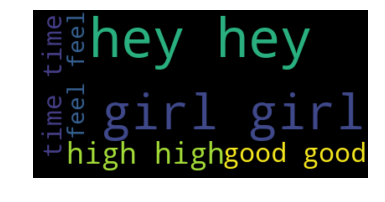

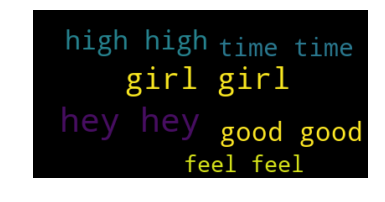

In [1891]:
# Generate a word cloud image
wordcloud = WordCloud().generate(str(n))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(str(n))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
# [(0,
#   '0.022*"hey" + 0.018*"girl" + 0.014*"high" + 0.013*"good" + 0.012*"time" + 0.012*"uh" + 0.012*"gotta" + 0.011*"night" + 0.011*"ride" + 0.010*"feel" + 0.010*"help" + 0.009*"long" + 0.009*"head" + 0.009*"day" + 0.009*"gonna" + 0.009*"love" + 0.008*"friends" + 0.008*"damn" + 0.008*"guess" + 0.008*"town"'),
#  (1,
#   '0.055*"bitch" + 0.052*"nigga" + 0.041*"shit" + 0.040*"niggas" + 0.036*"fuck" + 0.031*"money" + 0.017*"bitches" + 0.017*"pull" + 0.015*"hit" + 0.015*"real" + 0.015*"young" + 0.013*"lil" + 0.013*"pussy" + 0.013*"tryna" + 0.012*"girl" + 0.012*"bout" + 0.012*"ass" + 0.012*"fucking" + 0.010*"boy" + 0.009*"fuckin"'),
#  (2,
#   '0.045*"love" + 0.020*"will" + 0.019*"feel" + 0.018*"heart" + 0.017*"time" + 0.017*"girl" + 0.016*"night" + 0.012*"eyes" + 0.011*"stay" + 0.011*"hold" + 0.010*"keep" + 0.010*"tonight" + 0.010*"leave" + 0.009*"fall" + 0.009*"mine" + 0.009*"life" + 0.009*"find" + 0.009*"close" + 0.009*"gonna" + 0.009*"day"'),
#  (3,
#   '0.028*"life" + 0.027*"music" + 0.023*"song" + 0.020*"dance" + 0.020*"gonna" + 0.019*"love" + 0.018*"better" + 0.018*"mind" + 0.017*"people" + 0.015*"sing" + 0.015*"live" + 0.014*"time" + 0.014*"left" + 0.014*"change" + 0.013*"will" + 0.013*"crazy" + 0.012*"die" + 0.012*"hope" + 0.012*"beat" + 0.011*"god"')]

In [1941]:
n = ' '.join(['hey,' for s in range(22)])
n += ' '
n += ' '.join(['girl,' for s in range(18)])
n += ' '
n += ' '.join(['high,' for s in range(14)])
n += ' '
n += ' '.join(['time,' for s in range(12)])
n += ' '
n += ' '.join(['good,' for s in range(13)])
n += ' '
n += ' '.join(['feel,' for s in range(10)])
n += ' '
n += ' '.join(['night,' for s in range(11)])
n += ' '
n += ' '.join(['ride,' for s in range(11)])
n += ' '
n += ' '.join(['town,' for s in range(8)])
n += ' '
n += ' '.join(['friends,' for s in range(8)])
n += ' '
n += ' '.join(['day,' for s in range(9)])


In [1942]:
n

'hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, hey, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, girl, high, high, high, high, high, high, high, high, high, high, high, high, high, high, time, time, time, time, time, time, time, time, time, time, time, time, good, good, good, good, good, good, good, good, good, good, good, good, good, feel, feel, feel, feel, feel, feel, feel, feel, feel, feel, night, night, night, night, night, night, night, night, night, night, night, ride, ride, ride, ride, ride, ride, ride, ride, ride, ride, ride, town, town, town, town, town, town, town, town, friends, friends, friends, friends, friends, friends, friends, friends, day, day, day, day, day, day, day, day, day,'

In [1917]:
plot_text = []

count = 0
while count < len(df_info):
    plot_text.append(
       'Artist: ' + df_info.artist[count] + '<br>'
       + 'Song: ' + df_info.song[count] + '<br>'      
   )
    count += 1

In [2023]:
py.offline.init_notebook_mode(connected=True)
this_x3 = []
is_y3 = []
cool_z3 = []
for i in tsne_input:
    this_x3.append(i[0])
    is_y3.append(i[1])
    cool_z3.append(i[2])

trace = go.Scatter3d(
   x = this_x3,
   y = is_y3,
   z = cool_z3,
   text = plot_text,
   hoverinfo = 'text+text+text+text',
   mode = 'markers',
   marker = dict(
       size = 10,
       color = tsne_input.argmax(axis=1),                
       colorscale = 'Picnic',   
       opacity = 0.9
   )
)

plot_data = [trace]
layout = go.Layout(
   margin = dict(
       l = 0,
       r = 0,
       b = 0,
       t = 0
   )
)
fig = go.Figure(data = plot_data, layout = layout)
py.offline.iplot(fig)

## Song Topics in 3-D

## Song / Album Summarization

In [2030]:
from gensim.summarization.summarizer import summarize
from gensim.summarization.summarizer import summarize_corpus

In [2037]:
def lyrics_summarize(song_urls):
    song_info = []
    for i,_ in enumerate(song_urls):
        page = requests.get(song_urls[i])    
        html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string

        # Song name
        try:
            song_name = html.find("h1", class_="header_with_cover_art-primary_info-title").get_text().encode('ascii','ignore').decode('ascii')
            artist = html.find("a",class_='header_with_cover_art-primary_info-primary_artist').get_text().encode('ascii','ignore').decode('ascii')
            album = html.find("a", class_="song_album-info-title").get_text().encode('ascii','ignore').decode('ascii')
            lyrics = html.find("div", class_="lyrics").get_text().encode('ascii','ignore').decode('ascii')
            lyrics = html.find("div", class_="lyrics").get_text().encode('ascii','ignore').decode('ascii')
            lyrics = re.sub('\[.*\]','',lyrics) # Remove [Verse] and [Bridge] stuff
            #lyrics = re.sub('\n',' ',lyrics)  # Remove gaps between verses
            song_info.append(song_name)
            song_info.append(artist)
            song_info.append(album)
            song_info.append(lyrics)
        except:
            pass
    return song_info

In [2038]:
artist_list = ['mansionz']

mansionz = artist_album_list(artist_list)

mansionz_songs = album_song_list(mansionz)

mansionz = lyrics_summarize(mansionz_songs)

mansionz = mansionz[3::4]

In [2042]:
mansionz[3]

'\n\n\nSittin\' in the goddamn \'Lac\nRidin\' clean with my homies in the back\nIf you were me, you\'d do the same thang\nI got 20 women swimmin\' in my brain\nYeah, I\'m sittin\' in the goddamn \'Lac (Ya dig it)\nBangin\' Primo, yeah my shit boom bap (Ya dig it)\nGot the windows down, AC max (Woo)\nAnd we bumpin\' "Return of the Mack" (Ya dig it)\n\n\nI\'m gon\' do whatever it is I want to, baby\nI\'m gon\' do whatever it is I feel\nI don\'t care \'bout who\'s watching\nDennis Rodman\nDennis Rodman\n\n\nYeah, sittin\' in the clean Impala\nWe\'re class 2010, I\'m a scholar\nIf you were me, you\'d do the same thang\nMight hit Roscoe\'s, get a chicken wing\nYeah, sittin\' in the clean Impala (Ya dig it)\nFinna have you sippin\' on Odwalla\nAnd if you bad, then, baby, I\'ll holla (Hey, girl)\nMake your girl disappear, voila!\n\n\nI\'m gon\' do whatever it is I want to, baby\nI\'m gon\' do whatever it is I feel\nI don\'t care \'bout who\'s watching\nDennis Rodman\nDennis, Dennis, Dennis Ro

In [2081]:
print(summarize(mansionz[3], ratio=0.1))

2018-03-12 14:32:38,997 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-12 14:32:39,000 : INFO : built Dictionary(80 unique tokens: ['goddamn', 'lac', 'sittin', 'clean', 'homi']...) from 44 documents (total 144 corpus positions)


Yeah, I'm sittin' in the goddamn 'Lac (Ya dig it)
Yeah, sittin' in the clean Impala (Ya dig it)
Because a lot of people don't wanna talk about Dennis Rodman anymore because they think he's a has-been
I said, "I don't give a fuck, man, I'ma go do Dennis Rodman"


https://radimrehurek.com/gensim/summarization/summariser.html

https://arxiv.org/pdf/1602.03606.pdf

In [2095]:
print(summarize(mansionz[3], ratio=0.13))

2018-03-12 15:56:44,910 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-12 15:56:44,912 : INFO : built Dictionary(80 unique tokens: ['goddamn', 'lac', 'sittin', 'clean', 'homi']...) from 44 documents (total 144 corpus positions)


Yeah, I'm sittin' in the goddamn 'Lac (Ya dig it)
Yeah, sittin' in the clean Impala
Yeah, sittin' in the clean Impala (Ya dig it)
Because a lot of people don't wanna talk about Dennis Rodman anymore because they think he's a has-been
I said, "I don't give a fuck, man, I'ma go do Dennis Rodman"


In [2090]:
artist_list = ['Beyonce']

beyonce = artist_album_list(artist_list)

beyonce_songs = album_song_list(beyonce)

beyonce = lyrics_summarize(beyonce_songs)

beyonce = beyonce[3::4]

In [2099]:
print(summarize(beyonce[9], ratio=0.1))

2018-03-12 15:57:37,046 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-12 15:57:37,049 : INFO : built Dictionary(126 unique tokens: ['rain', 'thunder', 'tryna', 'new', 'storm']...) from 84 documents (total 224 corpus positions)


Tell the storm I'm new
Running blind in truth
Tell the sweet I'm new
Runnin' blind in truth
I'ma wade, I'ma wave through your shallow love
Cause I need freedom too!
Cause I need freedom too!
Cause I need freedom too!
